In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import e

In [2]:
T = 10
nsteps = 40
nsims = 1000
r0 = 0.02
alpha = 3
sigma = 0.01
theta0 = 0.03
beta = 1
phi = 0.05
eta = 0.005

In [3]:
def Sim_Brownian_Motion(t):
    # store the paths of the Brownian motion
    W = np.zeros(len(t))

    sqrt_dt = np.sqrt(t[1] - t[0])
    for i in range(len(t) - 1):
        W[i + 1] = W[i] + sqrt_dt * np.random.randn()

    return W

In [ ]:
def risk_neutral_int_elur(r0, alpha, beta, sigma, theta0, phi, eta, t, w_sim_r, w_sim_theta):
    dt = t[1] - t[0]

    theta_path = np.zeros(len(t))
    theta_path[0] = theta0

    r_path = np.zeros(len(t))
    r_path[0] = r0

    # Euler theta and r
    for i in range(len(t)-1):
        theta_path[i+1] = theta_path[i] + beta * (phi - theta_path[i]) * dt + eta * (w_sim_theta[i+1] - w_sim_theta[i])
        r_path[i+1] = r_path[i] + alpha * (theta_path[i] - r_path[i]) * dt + sigma * (w_sim_r[i+1] - w_sim_r[i])

    return theta_path, r_path

In [7]:
def bond_price(t1, t2, t, step, r_path):
    dt = t[1] - t[0]
    bank_account = np.zeros(int(t2 * step)+1)
    bank_account[0] = 1
    for i in range(0, t2 * step):
        bank_account[i+1] = bank_account[i] + r_path[i] * bank_account[i] * dt
        #bank_account[i+1] = bank_account[i]*np.exp(r_path[i]*dt) 
    return bank_account[t1 * step] / bank_account[t2 * step]

In [10]:
def analytic_a(alpha, beta, sigma, phi, eta, T, t):
    m = e ** -(alpha * (T - t))
    n = e ** -(beta * (T - t))
    p1 = - phi * (T - t)
    p2 = - phi * beta * (1 - m) / (alpha * (alpha - beta))
    p3 = phi * alpha * (1 - n) / (beta * (alpha - beta))
    pb = sigma ** 2 / (2 * alpha ** 2) * (T - t) \
        - sigma ** 2 * (1- m) / alpha ** 3 \
        + sigma ** 2 * (1 - m ** 2) / (4 * alpha ** 3)
    pc = eta ** 2 / (2 * beta ** 2) * (
        (T - t)
        + 2 * beta * (1 - m) / (alpha * (alpha - beta))
        - 2 * alpha * (1 - n) / (beta * (alpha - beta))
        + beta ** 2 * (1 - m ** 2) / (2 * alpha * (alpha - beta) ** 2)
        - 2 * alpha * beta * (1 - m * n) / ((alpha + beta) * (alpha - beta) ** 2)
        + alpha ** 2 * (1 - n ** 2) / (2 * beta * (alpha - beta) ** 2)
    )

    return p1 + p2 + p3 + pb + pc


def analytic_b(alpha, T, t):
    return (1 - e ** -(alpha * (T - t))) / alpha


def analytic_c(alpha, beta, T, t):
    return (1 / beta
            + (beta * e ** -(alpha * (T - t)) - alpha * e ** -(beta * (T - t))) / (beta * (alpha - beta)))

In [126]:
def analytic_formula(r0, alpha, beta, sigma, theta0, phi, eta, T, t):
    return np.exp(- analytic_b(alpha, T, t) * r0
                  - analytic_c(alpha, beta, T, t) * theta0
                  + analytic_a(alpha, beta, sigma, phi, eta, T, t))

In [8]:
#New
def bank_account(t1, t2, t, step, r_path):
    dt = t[1] - t[0]
    bank_account = np.zeros(int(t2 * step)+1)
    bank_account[0] = 1
    for i in range(0, t2 * step):
        bank_account[i+1] = bank_account[i] + r_path[i] * bank_account[i] * dt
        #bank_account[i+1] = bank_account[i]*np.exp(r_path[i]*dt) 
    return bank_account

In [105]:
#New
def forward_neutral_int_elur(T1, T2, r0, alpha, beta, sigma, theta0, phi, eta, t, w_sim_r, w_sim_theta):
    dt = t[1] - t[0]

    theta_path_for = np.zeros(len(t))
    theta_path_for[0] = theta0

    r_path_for = np.zeros(len(t))
    r_path_for[0] = r0

    # Euler theta and r
    for i in range(len(t)-1):

        B_T1 = analytic_b(alpha, T1, t[i])
        B_T2 = analytic_b(alpha, T2, t[i])
        C_T1 = analytic_c(alpha, beta, T1, t[i])
        C_T2 = analytic_c(alpha, beta, T2, t[i])
        
        lambda1 = sigma*(B_T1**2) / (B_T1-B_T2)
        lambda2 = eta*(C_T1**2) / (C_T1-C_T2)
        
        theta_path_for[i+1] = theta_path_for[i] + (beta * (phi - theta_path_for[i]) - lambda2*eta) * dt + eta * (w_sim_theta[i+1] - w_sim_theta[i])
        r_path_for[i+1] = r_path_for[i] + (alpha * (theta_path_for[i] - r_path_for[i]) - lambda1*sigma) * dt + sigma * (w_sim_r[i+1] - w_sim_r[i])

    return theta_path_for, r_path_for


In [113]:
#New
def forward_bond_price_T1(t1, t2, t, step, r_path, alpha, beta, sigma, eta):
    dt = t[1] - t[0]
    bank_account = np.zeros(int(t2 * step)+1)
    bank_account[0] = 1
    for i in range(0, t2 * step):

        B_T1 = analytic_b(alpha, T1, t[i])
        B_T2 = analytic_b(alpha, T2, t[i])
        C_T1 = analytic_c(alpha, beta, T1, t[i])
        C_T2 = analytic_c(alpha, beta, T2, t[i])
        
        lambda1 = sigma*(B_T1**2) / (B_T1-B_T2)
        lambda2 = eta*(C_T1**2) / (C_T1-C_T2)
        
        bank_account[i+1] = bank_account[i] + (r_path[i] + lambda1*B_T1*sigma + lambda2*C_T1*eta)* bank_account[i] * dt
        #bank_account[i+1] = bank_account[i]*np.exp(r_path[i]*dt) 
    return bank_account[t1 * step] / bank_account[t2 * step]

In [114]:
#New
def forward_bond_price_T2(t1, t2, t, step, r_path, alpha, beta, sigma, eta):
    dt = t[1] - t[0]
    bank_account = np.zeros(int(t2 * step)+1)
    bank_account[0] = 1
    for i in range(0, t2 * step):

        B_T1 = analytic_b(alpha, T1, t[i])
        B_T2 = analytic_b(alpha, T2, t[i])
        C_T1 = analytic_c(alpha, beta, T1, t[i])
        C_T2 = analytic_c(alpha, beta, T2, t[i])
        
        lambda1 = sigma*(B_T1**2) / (B_T1-B_T2)
        lambda2 = eta*(C_T1**2) / (C_T1-C_T2)
        
        bank_account[i+1] = bank_account[i] + (r_path[i] + lambda1*B_T2*sigma + lambda2*C_T2*eta)* bank_account[i] * dt
        #bank_account[i+1] = bank_account[i]*np.exp(r_path[i]*dt) 
    return bank_account[t1 * step] / bank_account[t2 * step]

In [115]:
#New
def forward_bank_account(t1, t2, t, step, r_path, alpha, beta, sigam, eta):
    dt = t[1] - t[0]
    bank_account = np.zeros(int(t2 * step)+1)
    bank_account[0] = 1
    for i in range(0, t2 * step):

        B_T1 = analytic_b(alpha, T1, t[i])
        B_T2 = analytic_b(alpha, T2, t[i])
        C_T1 = analytic_c(alpha, beta, T1, t[i])
        C_T2 = analytic_c(alpha, beta, T2, t[i])
        
        lambda1 = sigma*(B_T1**2) / (B_T1-B_T2)
        lambda2 = eta*(C_T1**2) / (C_T1-C_T2)
        
        bank_account[i+1] = bank_account[i] + (r_path[i] + lambda1*B_T1*sigma + lambda2*C_T1*eta)* bank_account[i] * dt
        #bank_account[i+1] = bank_account[i]*np.exp(r_path[i]*dt) 
    return bank_account

### Q4

In [12]:
# Analytic Version\
T1 = 3
T2 = 5

In [13]:
def H1_sq(t1, t2, t, alpha, sigma):
    m1 = np.exp(-alpha*(t1-t))
    m2 = np.exp(-alpha*(t2-t))
    
    temp_H1 = sigma**2/(2*alpha**3) * ((np.exp(-alpha*(t2-t1))-1)**2 - (m2-m1)**2)
    return temp_H1

In [14]:
def H2_sq(t1, t2, t, alpha, beta, sigma, eta):
    
    m1 = np.exp(-alpha*(t1-t))
    m2 = np.exp(-alpha*(t2-t))
    n1 = np.exp(-beta*(t1-t))
    n2 = np.exp(-beta*(t2-t))
    
    p1 = beta**2/(2*alpha) * ((np.exp(-alpha*(t2-t1))-1)**2 - (m2-m1)**2)
    p2 = -2*alpha*beta/(alpha+beta) *((np.exp(-alpha*(t2-t1))-1)*(np.exp(-beta*(t2-t1))-1) - (m2-m1)*(n2-n1))
    p3 = alpha**2/(2*beta) * ((np.exp(-beta*(t2-t1))-1)**2 - (n2-n1)**2)
    
    H2_temp = eta**2/(beta**2 * (alpha-beta)**2) * (p1+p2+p3)
    
    return H2_temp

In [129]:
P0_T1 = analytic_formula(r0, alpha, beta, sigma, theta0, phi, eta, T1, 0)
P0_T2 = analytic_formula(r0, alpha, beta, sigma, theta0, phi, eta, T2, 0)
K = P0_T2/P0_T1

In [133]:
H1_T1_sq = H1_sq(T1, T2, 0, alpha, sigma)
H2_T1_sq = H2_sq(T1, T2, 0, alpha, beta, sigma, eta)

In [151]:
K_steps = 11
K_factor = np.linspace(0.95, 1.05, K_steps)
g_T1 = np.zeros(K_steps)

for i in range(0, K_steps):
    
    K_temp = K*K_factor[i]
    
    d1 = (np.log(P0_T2/(K_temp*P0_T1)) + 0.5*(H1_T1_sq+H2_T1_sq))/(np.sqrt(H1_T1_sq+H2_T1_sq))
    d2 = (np.log(P0_T2/(K_temp*P0_T1)) - 0.5*(H1_T1_sq+H2_T1_sq))/(np.sqrt(H1_T1_sq+H2_T1_sq))
    g_T1[i] = P0_T2*norm.cdf(d1) - P0_T1*K_temp*norm.cdf(d2)

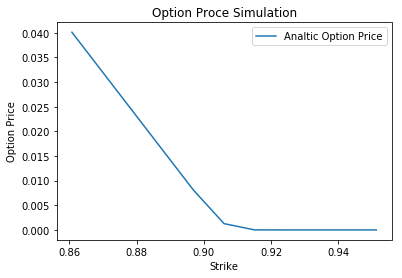

In [152]:
plt.plot(K*K_factor, g_T1, label='Analtic Option Price')
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title('Option Proce Simulation')
plt.legend()

In [17]:
# Risk-Netrual MC simulation
theta_path_set = np.zeros((nsims, nsteps))
r_path_set = np.zeros((nsims, nsteps))
t = np.linspace(0, T2, nsteps)
steps = int(nsteps / T2)

for i in range(0, nsims):
    w_sim_r = Sim_Brownian_Motion(t)
    w_sim_theta = Sim_Brownian_Motion(t)
    [theta_path_set[i:], r_path_set[i:]] = risk_neutral_int_elur(r0, alpha, beta, sigma, theta0, phi, eta, t, w_sim_r, w_sim_theta)
int_matrix = r_path_set.reshape(nsims, nsteps)

In [157]:
K_steps = 11
K_factor = np.linspace(0.95, 1.05, K_steps)

p0_t1_sim = np.zeros(nsims)
p0_t2_sim = np.zeros(nsims)
pt1_t2_sim = np.zeros(nsims)
option_price = np.zeros([nsims,K_steps])
K_sim = np.zeros(nsims)
K_temp_sim = np.zeros(nsims)
g_T_risk_sim = np.zeros(K_steps)
K_final = np.zeros(K_steps)

for i in range(0, K_steps):
    for n in range(0, nsims):
        p0_t1_sim[n] = bond_price(0, T1, t, steps, int_matrix[n])
        p0_t2_sim[n] = bond_price(0, T2, t, steps, int_matrix[n])
        pt1_t2_sim[n] = bond_price(T1, T2, t, steps, int_matrix[n])
        K_sim[n] = p0_t2_sim[n] / p0_t1_sim[n]
        #K_sim[n] = P0_T2/P0_T1
        K_temp_sim[n] = K_sim[n] * K_factor[i]
        discount = bank_account(0, T2, t, steps, int_matrix[n])
        option_price[n, i] = np.maximum((pt1_t2_sim[n] - K_temp_sim[n]), 0)/discount[T1 * steps]
    g_T_risk_sim[i] = np.mean(option_price[:, i])
    K_final[i] = np.mean(K_temp_sim)

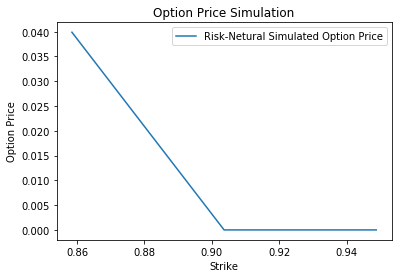

In [158]:
plt.plot(K_final, g_T_risk_sim, label='Risk-Netural Simulated Option Price')
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title('Option Price Simulation')
plt.legend()

In [107]:
# MC simulation Forward-netural
theta_path_set_for = np.zeros((nsims, nsteps))
r_path_set_for = np.zeros((nsims, nsteps))
t = np.linspace(0, T2, nsteps)
steps = int(nsteps / T2)

for i in range(0, nsims):
    w_sim_r = Sim_Brownian_Motion(t)
    w_sim_theta = Sim_Brownian_Motion(t)
    [theta_path_set_for[i:], r_path_set_for[i:]] = forward_neutral_int_elur(T1, T2, r0, alpha, beta, sigma, theta0, phi, eta, t, w_sim_r, w_sim_theta)
int_matrix_for = r_path_set_for.reshape(nsims, nsteps)


In [159]:
K_steps = 11
K_factor = np.linspace(0.95, 1.05, K_steps)

p0_t1_for_sim = np.zeros(nsims)
p0_t2_for_sim = np.zeros(nsims)
pt1_t2_for_sim = np.zeros(nsims)
option_price_for = np.zeros([nsims,K_steps])
K_for_sim = np.zeros(nsims)
K_temp_for_sim = np.zeros(nsims)
g_T_forward_sim = np.zeros(K_steps)
K_final_for = np.zeros(K_steps)

for i in range(0, K_steps):
    for n in range(0, nsims):
        p0_t1_for_sim[n] = forward_bond_price_T1(0, T1, t, steps, int_matrix_for[n], alpha, beta, sigma, eta)
        p0_t2_for_sim[n] = forward_bond_price_T2(0, T2, t, steps, int_matrix_for[n], alpha, beta, sigma, eta)
        pt1_t2_for_sim[n] = forward_bond_price_T2(T1, T2, t, steps, int_matrix_for[n], alpha, beta, sigma, eta)
        K_for_sim[n] = p0_t2_for_sim[n] / p0_t1_for_sim[n]
        #K_for_sim[n] = P0_T2/P0_T1
        K_temp_for_sim[n] = K_for_sim[n] * K_factor[i]
        discount_for = forward_bank_account(0, T2, t, steps, int_matrix_for[n], alpha, beta, sigma,eta)
        option_price_for[n, i] = np.maximum((pt1_t2_for_sim[n] - K_temp_for_sim[n]), 0)/discount_for[T1 * steps]
    g_T_forward_sim[i] = np.mean(option_price_for[:, i])
    K_final_for[i] = np.mean(K_temp_for_sim)

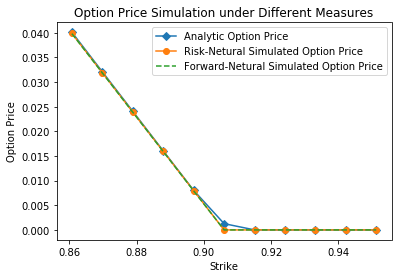

In [160]:
plt.plot(K*K_factor, g_T1, '-D', label='Analytic Option Price')
plt.plot(K*K_factor, g_T_risk_sim, '-o', label='Risk-Netural Simulated Option Price')
plt.plot(K*K_factor, g_T_forward_sim, '--',label = 'Forward-Netural Simulated Option Price')
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title('Option Price Simulation under Different Measures')
plt.legend()